In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from numpy.fft import fft2, ifft2 
from scipy.fft import next_fast_len 
from scipy.sparse import diags 
import matplotlib.pyplot as plt

# --- Updated default params to include kernel specification ---
default_params = {
        "nx": 50, "bord": 5, "T": 100,
        "mu": 4e-3, "gamma": 0.3, 'eta': 1e-3,
        "r_v": 1, "alpha": 0.025, "beta": 0.025,
        "K_cap": 1e8, "kappa": 1e-7, "sigma": 1,
        "V0_total": 1e6, "v_init_pos": [1, 1],
        "D0_total": 1e6, "d_init_pos": [1.4, 0],
        "init_spread": 0.4, "monitor_extinction": True,
        "extinction_threshold_V": 1e2, "extinction_threshold_D": 1e2,
        "kernel_type": "gaussian",  # or "exponential", "step", "power_law", "laplacian", "rational", "sinc", "ring"
        "kernel_params": {"sigma": 1}  # parameters specific to each kernel type
    }

# --- Individual kernel functions ---
def gaussian_kernel(params, padded_nx, padded_ny, dx, dy):
    """Original Gaussian kernel: exp(-r²/(2σ²))"""
    sigma = params.get("sigma", 0.5)
    if sigma <= 1e-9:
        return np.ones((padded_ny, padded_nx), dtype=complex)
    
    sigma_sq = sigma**2
    ix, iy = np.arange(padded_nx), np.arange(padded_ny)
    ixx, iyy = np.meshgrid(ix, iy)
    
    dist_x_sq = (np.minimum(ixx, padded_nx - ixx) * dx)**2
    dist_y_sq = (np.minimum(iyy, padded_ny - iyy) * dy)**2
    
    kernel = np.exp(-(dist_x_sq + dist_y_sq) / (2 * sigma_sq))
    kernel_sum = np.sum(kernel) * dx * dy
    if kernel_sum > 1e-9:
        kernel /= kernel_sum
    return fft2(kernel)

def exponential_kernel(params, padded_nx, padded_ny, dx, dy):
    """Exponential kernel: exp(-r/λ)"""
    lambda_param = params.get("lambda", 0.5)
    if lambda_param <= 1e-9:
        return np.ones((padded_ny, padded_nx), dtype=complex)
    
    ix, iy = np.arange(padded_nx), np.arange(padded_ny)
    ixx, iyy = np.meshgrid(ix, iy)
    
    dist_x = np.minimum(ixx, padded_nx - ixx) * dx
    dist_y = np.minimum(iyy, padded_ny - iyy) * dy
    dist_r = np.sqrt(dist_x**2 + dist_y**2)
    
    kernel = np.exp(-dist_r / lambda_param)
    kernel_sum = np.sum(kernel) * dx * dy
    if kernel_sum > 1e-9:
        kernel /= kernel_sum
    return fft2(kernel)

def step_kernel(params, padded_nx, padded_ny, dx, dy):
    """Step function kernel: 1 if r <= radius, 0 otherwise"""
    radius = params.get("radius", 0.5)
    if radius <= 1e-9:
        kernel = np.zeros((padded_ny, padded_nx))
        kernel[0, 0] = 1.0
        return fft2(kernel)
    
    ix, iy = np.arange(padded_nx), np.arange(padded_ny)
    ixx, iyy = np.meshgrid(ix, iy)
    
    dist_x = np.minimum(ixx, padded_nx - ixx) * dx
    dist_y = np.minimum(iyy, padded_ny - iyy) * dy
    dist_r = np.sqrt(dist_x**2 + dist_y**2)
    
    kernel = (dist_r <= radius).astype(float)
    kernel_sum = np.sum(kernel) * dx * dy
    if kernel_sum > 1e-9:
        kernel /= kernel_sum
    return fft2(kernel)

def power_law_kernel(params, padded_nx, padded_ny, dx, dy):
    """Power law kernel: (r₀/(r₀ + r))^α"""
    alpha = params.get("alpha", 2.0)
    r0 = params.get("r0", 0.1)
    
    ix, iy = np.arange(padded_nx), np.arange(padded_ny)
    ixx, iyy = np.meshgrid(ix, iy)
    
    dist_x = np.minimum(ixx, padded_nx - ixx) * dx
    dist_y = np.minimum(iyy, padded_ny - iyy) * dy
    dist_r = np.sqrt(dist_x**2 + dist_y**2)
    
    kernel = (r0 / (r0 + dist_r))**alpha
    kernel_sum = np.sum(kernel) * dx * dy
    if kernel_sum > 1e-9:
        kernel /= kernel_sum
    return fft2(kernel)

def laplacian_kernel(params, padded_nx, padded_ny, dx, dy):
    """Laplacian kernel: exp(-|r|/b)"""
    b = params.get("b", 0.5)
    if b <= 1e-9:
        return np.ones((padded_ny, padded_nx), dtype=complex)
    
    ix, iy = np.arange(padded_nx), np.arange(padded_ny)
    ixx, iyy = np.meshgrid(ix, iy)
    
    dist_x = np.minimum(ixx, padded_nx - ixx) * dx
    dist_y = np.minimum(iyy, padded_ny - iyy) * dy
    dist_r = np.sqrt(dist_x**2 + dist_y**2)
    
    kernel = np.exp(-dist_r / b)
    kernel_sum = np.sum(kernel) * dx * dy
    if kernel_sum > 1e-9:
        kernel /= kernel_sum
    return fft2(kernel)

def rational_kernel(params, padded_nx, padded_ny, dx, dy):
    """Rational kernel: 1/(1 + (r/σ)²)"""
    sigma = params.get("sigma", 0.5)
    if sigma <= 1e-9:
        return np.ones((padded_ny, padded_nx), dtype=complex)
    
    ix, iy = np.arange(padded_nx), np.arange(padded_ny)
    ixx, iyy = np.meshgrid(ix, iy)
    
    dist_x = np.minimum(ixx, padded_nx - ixx) * dx
    dist_y = np.minimum(iyy, padded_ny - iyy) * dy
    dist_r = np.sqrt(dist_x**2 + dist_y**2)
    
    kernel = 1.0 / (1.0 + (dist_r / sigma)**2)
    kernel_sum = np.sum(kernel) * dx * dy
    if kernel_sum > 1e-9:
        kernel /= kernel_sum
    return fft2(kernel)

def sinc_kernel(params, padded_nx, padded_ny, dx, dy):
    """Sinc kernel: sin(πr/a)/(πr/a) for oscillatory interactions"""
    a = params.get("a", 0.5)
    if a <= 1e-9:
        return np.ones((padded_ny, padded_nx), dtype=complex)
    
    ix, iy = np.arange(padded_nx), np.arange(padded_ny)
    ixx, iyy = np.meshgrid(ix, iy)
    
    dist_x = np.minimum(ixx, padded_nx - ixx) * dx
    dist_y = np.minimum(iyy, padded_ny - iyy) * dy
    dist_r = np.sqrt(dist_x**2 + dist_y**2)
    
    # Handle r=0 case
    kernel = np.ones_like(dist_r)
    mask = dist_r > 1e-12
    kernel[mask] = np.sin(np.pi * dist_r[mask] / a) / (np.pi * dist_r[mask] / a)
    
    kernel_sum = np.sum(kernel) * dx * dy
    if kernel_sum > 1e-9:
        kernel /= kernel_sum
    return fft2(kernel)

def ring_kernel(params, padded_nx, padded_ny, dx, dy):
    """Ring/annulus kernel: interactions at specific distance ranges"""
    r_inner = params.get("r_inner", 0.3)
    r_outer = params.get("r_outer", 0.7)
    
    ix, iy = np.arange(padded_nx), np.arange(padded_ny)
    ixx, iyy = np.meshgrid(ix, iy)
    
    dist_x = np.minimum(ixx, padded_nx - ixx) * dx
    dist_y = np.minimum(iyy, padded_ny - iyy) * dy
    dist_r = np.sqrt(dist_x**2 + dist_y**2)
    
    kernel = ((dist_r >= r_inner) & (dist_r <= r_outer)).astype(float)
    kernel_sum = np.sum(kernel) * dx * dy
    if kernel_sum > 1e-9:
        kernel /= kernel_sum
    else:
        # If ring is empty, fall back to delta function
        kernel = np.zeros_like(kernel)
        kernel[0, 0] = 1.0
    return fft2(kernel)

# --- Main kernel dispatcher ---
def create_interaction_kernel(kernel_type, kernel_params, padded_nx, padded_ny, dx, dy):
    """
    Create an interaction kernel of the specified type with given parameters.
    
    Parameters:
    -----------
    kernel_type : str
        Type of kernel ('gaussian', 'exponential', 'step', 'power_law', 'laplacian', 'rational', 'sinc', 'ring')
    kernel_params : dict
        Parameters specific to the kernel type
    padded_nx, padded_ny : int
        Padded dimensions for FFT
    dx, dy : float
        Grid spacing
        
    Returns:
    --------
    fft_kernel : ndarray
        FFT of the normalized kernel
    """
    kernel_functions = {
        'gaussian': gaussian_kernel,
        'exponential': exponential_kernel,
        'step': step_kernel,
        'power_law': power_law_kernel,
        'laplacian': laplacian_kernel,
        'rational': rational_kernel,
        'sinc': sinc_kernel,
        'ring': ring_kernel
    }
    
    if kernel_type not in kernel_functions:
        raise ValueError(f"Unknown kernel type: {kernel_type}. Available types: {list(kernel_functions.keys())}")
    
    return kernel_functions[kernel_type](kernel_params, padded_nx, padded_ny, dx, dy)

# --- Rest of the helper functions remain the same ---
def event_virus_extinction_simplified(t, QL, A, B, PHENOx, PHENOy, _fft_K_exp_argument, params_dict):
    nx, ny, dx, dy = params_dict['nx'], params_dict['nx'], params_dict['dx'], params_dict['dy']
    current_V_total = np.sum(np.maximum(0, QL[:nx * ny])) * dx * dy
    return current_V_total - params_dict.get('extinction_threshold_V', 1e-2)
event_virus_extinction_simplified.terminal = True
event_virus_extinction_simplified.direction = -1

def event_dip_extinction_simplified(t, QL, A, B, PHENOx, PHENOy, _fft_K_exp_argument, params_dict):
    nx, ny, dx, dy = params_dict['nx'], params_dict['nx'], params_dict['dx'], params_dict['dy']
    current_D_total = np.sum(np.maximum(0, QL[nx * ny:])) * dx * dy
    return current_D_total - params_dict.get('extinction_threshold_D', 1e-2)
event_dip_extinction_simplified.terminal = False
event_dip_extinction_simplified.direction = -1

def count_local_maxima(density, threshold):
    if np.max(density) < threshold: return 0
    ny, nx = density.shape; count = 0
    for i in range(1, ny - 1):
        for j in range(1, nx - 1):
            if density[i, j] >= threshold and np.all(density[i, j] > density[i-1:i+2, j-1:j+2]):
                count += 1
    return max(1, count) if np.max(density) >= threshold and count == 0 else count

def calculate_distribution_shape_stats(density, PHENOx, PHENOy, dx, dy, min_total=1e-9):
    total_mass = np.sum(density) * dx * dy
    nan_keys = ['variance_x', 'variance_y', 'skewness_x', 'skewness_y', 'kurtosis_x', 'kurtosis_y', 'mean_distance_from_origin', 'variance_distance_from_origin', 'anisotropy_ratio', 'effective_radius', 'compactness', 'max_density']
    if total_mass < min_total:
        return {k: np.nan for k in nan_keys} | {'num_clusters': 0}
    prob_density = density / np.sum(density)
    mean_x = np.sum(PHENOx * prob_density); mean_y = np.sum(PHENOy * prob_density)
    dx_centered, dy_centered = PHENOx - mean_x, PHENOy - mean_y
    variance_x, variance_y = np.sum(dx_centered**2 * prob_density), np.sum(dy_centered**2 * prob_density)
    skewness_x = np.sum(dx_centered**3 * prob_density) / (variance_x**1.5) if variance_x > 1e-12 else 0.0
    skewness_y = np.sum(dy_centered**3 * prob_density) / (variance_y**1.5) if variance_y > 1e-12 else 0.0
    kurtosis_x = np.sum(dx_centered**4 * prob_density) / (variance_x**2) - 3.0 if variance_x > 1e-12 else 0.0
    kurtosis_y = np.sum(dy_centered**4 * prob_density) / (variance_y**2) - 3.0 if variance_y > 1e-12 else 0.0
    distances = np.sqrt(PHENOx**2 + PHENOy**2); mean_distance = np.sum(distances * prob_density)
    variance_distance = np.sum((distances - mean_distance)**2 * prob_density)
    cov_xy = np.sum(dx_centered * dy_centered * prob_density)
    trace, det = variance_x + variance_y, variance_x * variance_y - cov_xy**2
    if trace > 1e-12 and det >= 0:
        sqrt_discriminant = np.sqrt(max(0, trace**2 - 4 * det))
        eigenval1, eigenval2 = (trace + sqrt_discriminant) / 2, (trace - sqrt_discriminant) / 2
        anisotropy_ratio = eigenval1 / eigenval2 if eigenval2 > 1e-12 else np.inf
    else: anisotropy_ratio = 1.0
    effective_radius = np.sqrt(variance_x + variance_y)
    max_density = np.max(density)
    compactness = max_density / (effective_radius + 1e-12)
    num_clusters = count_local_maxima(density, 0.1 * max_density)
    return {'variance_x': variance_x, 'variance_y': variance_y, 'skewness_x': skewness_x, 'skewness_y': skewness_y, 'kurtosis_x': kurtosis_x, 'kurtosis_y': kurtosis_y, 'mean_distance_from_origin': mean_distance, 'variance_distance_from_origin': variance_distance, 'anisotropy_ratio': anisotropy_ratio, 'effective_radius': effective_radius, 'compactness': compactness, 'num_clusters': num_clusters, 'max_density': max_density}

# --- Updated PDE function ---
def dip_virus_pde_fft_padded(t, QL, A, B, PHENOx, PHENOy, passed_fft_K_exp, params):
    nx, ny, dx, dy = params['nx'], params['nx'], params['dx'], params['dy']
    padded_nx, padded_ny = params['padded_nx'], params['padded_ny']
    mu, K_cap, kappa, gamma, eta = params["mu"], params["K_cap"], params["kappa"], params["gamma"], params['eta']
    v_density = np.maximum(0, QL[:nx * ny]).reshape(ny, nx)
    d_density = np.maximum(0, QL[nx * ny:]).reshape(ny, nx)
    V_total, D_total = np.sum(v_density) * dx * dy, np.sum(d_density) * dx * dy
    xbarV = [np.sum(PHENOx * v_density) * dx * dy / V_total, np.sum(PHENOy * v_density) * dx * dy / V_total] if V_total > 1e-9 else [0.0, 0.0]
    logistic_factor = (1 - (V_total + D_total) / max(K_cap, 1e-12))
    v_padded, d_padded = np.zeros((padded_ny, padded_nx)), np.zeros((padded_ny, padded_nx))
    v_padded[:ny, :nx], d_padded[:ny, :nx] = v_density, d_density
    fft_v_padded, fft_d_padded = fft2(v_padded), fft2(d_padded)
    conv_exp_d_spatial = np.real(ifft2(passed_fft_K_exp * fft_d_padded))[:ny, :nx]
    conv_exp_v_spatial = np.real(ifft2(passed_fft_K_exp * fft_v_padded))[:ny, :nx]
    interference_rate_on_v = kappa * conv_exp_d_spatial 
    interference_gain_for_d = kappa * conv_exp_v_spatial
    r_v_map = (params["r_v"] - eta - params["alpha"] * (PHENOx**2 + PHENOy**2) - params["beta"] * ((xbarV[0]-PHENOx)**2 + (xbarV[1]-PHENOy)**2))
    dv_dt = (mu * (v_density @ A + B @ v_density) + (r_v_map * v_density - v_density * interference_rate_on_v) * logistic_factor - gamma * v_density)
    dd_dt = (mu * (d_density @ A + B @ d_density) + (d_density * interference_gain_for_d + v_density * eta) * logistic_factor - gamma * d_density)
    return np.concatenate([dv_dt.flatten(), dd_dt.flatten()])

# --- Updated main solver function ---
def sol_dip_virus_pde_fft(params, initial_v_density=None, initial_d_density=None, 
                          save_density_series=True):
    """
    Main solver function with interchangeable kernel types.
    """
    upd_params = default_params.copy(); upd_params.update(params)
    upd_params.update({'save_density_series': save_density_series})
    nx, ny, bord = upd_params['nx'], upd_params['nx'], upd_params['bord']
    padded_nx, padded_ny = next_fast_len(2*nx-1), next_fast_len(2*ny-1)
    upd_params.update({'padded_nx': padded_nx, 'padded_ny': padded_ny})
    dx = dy = (2.0 * bord) / nx
    x_centers, y_centers = np.linspace(-bord+dx/2, bord-dx/2, nx), np.linspace(-bord+dy/2, bord-dy/2, ny)
    PHENOx, PHENOy = np.meshgrid(x_centers, y_centers)
    upd_params.update({"dx": dx, "dy": dy})
    
    # --- Initial condition setup (unchanged) ---
    init_spread = upd_params.get("init_spread", 0.2)
    
    if init_spread < (dx / 2):
        print(f"Warning: init_spread ({init_spread:.2e}) is smaller than half the grid spacing ({dx/2:.2e}). Using a single-point initial condition to avoid numerical instability.")
        v_init = np.zeros_like(PHENOx)
        v_idx_y = np.argmin(np.abs(y_centers - upd_params["v_init_pos"][1]))
        v_idx_x = np.argmin(np.abs(x_centers - upd_params["v_init_pos"][0]))
        v_init[v_idx_y, v_idx_x] = upd_params["V0_total"] / (dx * dy)
        
        d_init = np.zeros_like(PHENOx)
        d_idx_y = np.argmin(np.abs(y_centers - upd_params["d_init_pos"][1]))
        d_idx_x = np.argmin(np.abs(x_centers - upd_params["d_init_pos"][0]))
        d_init[d_idx_y, d_idx_x] = upd_params["D0_total"] / (dx * dy)
    else:
        v_init_gauss = np.exp(-((PHENOx - upd_params["v_init_pos"][0])**2 + (PHENOy - upd_params["v_init_pos"][1])**2) / (2 * init_spread**2))
        v_init = v_init_gauss * (upd_params["V0_total"] / max(np.sum(v_init_gauss) * dx * dy, 1e-12))
        
        d_init_gauss = np.exp(-((PHENOx - upd_params["d_init_pos"][0])**2 + (PHENOy - upd_params["d_init_pos"][1])**2) / (2 * init_spread**2))
        d_init = d_init_gauss * (upd_params["D0_total"] / max(np.sum(d_init_gauss) * dx * dy, 1e-12))
    
    Q0 = np.concatenate([v_init.flatten(), d_init.flatten()])
    
    A_1D = diags([-2,1,1], [0,-1,1], shape=(nx,nx)).toarray(); A_1D[0,1]=2; A_1D[-1,-2]=2; A=A_1D/dx**2
    B_1D = diags([-2,1,1], [0,-1,1], shape=(ny,ny)).toarray(); B_1D[0,1]=2; B_1D[-1,-2]=2; B=B_1D/dy**2
    
    # --- NEW: Create interaction kernel using the flexible system ---
    kernel_type = upd_params.get('kernel_type', 'gaussian')
    kernel_params = upd_params.get('kernel_params', {'sigma': 0.5})
    
    fft_K_exp = create_interaction_kernel(kernel_type, kernel_params, padded_nx, padded_ny, dx, dy)
    
    events, event_names = [], []
    if upd_params.get('monitor_extinction', False):
        events.extend([event_virus_extinction_simplified, event_dip_extinction_simplified])
        
    sol = solve_ivp(fun=dip_virus_pde_fft_padded, t_span=[0, upd_params['T']], y0=Q0, method='RK45', 
                    rtol=1e-6, atol=1e-9, args=(A, B, PHENOx, PHENOy, fft_K_exp, upd_params), 
                    events=events or None)
                    
    termination_reason = 't_end_reached'
    if sol.status == 1:
        for i, event_list in enumerate(sol.t_events):
            if event_list.size > 0:
                if i == 0: termination_reason = 'Virus Extinction'
                break
    elif sol.status < 0: 
        termination_reason = 'Solver Error'
        
    dip_extinction_count = len(sol.t_events[1]) if events and len(sol.t_events) > 1 and sol.t_events[1] is not None else 0
    
    # --- Data processing (unchanged) ---
    num_t = len(sol.t)
    V_total_time, D_total_time = np.zeros(num_t), np.zeros(num_t)
    mean_phenotype_v, mean_phenotype_d = np.full((num_t, 2), np.nan), np.full((num_t, 2), np.nan)
    shape_stats_v_list, shape_stats_d_list = [], []
    
    v_indices = slice(0, nx * ny)
    d_indices = slice(nx * ny, None)
    
    for i in range(num_t):
        v_density = np.maximum(0, sol.y[v_indices, i]).reshape(ny, nx)
        d_density = np.maximum(0, sol.y[d_indices, i]).reshape(ny, nx)
        
        V_total_time[i] = np.sum(v_density) * dx * dy
        D_total_time[i] = np.sum(d_density) * dx * dy

        if V_total_time[i] > 1e-12:
            mean_phenotype_v[i, 0] = np.sum(PHENOx * v_density) * dx * dy / V_total_time[i]
            mean_phenotype_v[i, 1] = np.sum(PHENOy * v_density) * dx * dy / V_total_time[i]
        
        if D_total_time[i] > 1e-12:
            mean_phenotype_d[i, 0] = np.sum(PHENOx * d_density) * dx * dy / D_total_time[i]
            mean_phenotype_d[i, 1] = np.sum(PHENOy * d_density) * dx * dy / D_total_time[i]
            
        shape_stats_v_list.append(calculate_distribution_shape_stats(v_density, PHENOx, PHENOy, dx, dy))
        shape_stats_d_list.append(calculate_distribution_shape_stats(d_density, PHENOx, PHENOy, dx, dy))
        
    shape_keys = shape_stats_v_list[0].keys() if shape_stats_v_list else {}
    shape_stats_v = {key: np.array([s[key] for s in shape_stats_v_list]) for key in shape_keys}
    shape_stats_d = {key: np.array([s[key] for s in shape_stats_d_list]) for key in shape_keys}
    
    base_results = {
        "time_points": sol.t, "V_total_time": V_total_time, "D_total_time": D_total_time,
        "mean_phenotype_v": mean_phenotype_v, "mean_phenotype_d": mean_phenotype_d,
        "shape_stats_v": shape_stats_v, "shape_stats_d": shape_stats_d,
        "params": upd_params, "success": sol.success, "termination_reason": termination_reason,
        "dip_extinction_count": dip_extinction_count
    }
    
    if upd_params['save_density_series']:
        v_series_3d = sol.y[v_indices, :].T.reshape(num_t, ny, nx)
        d_series_3d = sol.y[d_indices, :].T.reshape(num_t, ny, nx)
        v_series_transposed = v_series_3d.transpose((1, 2, 0))
        d_series_transposed = d_series_3d.transpose((1, 2, 0))
        
        base_results.update({
            "v_dist_time": v_series_transposed,
            "d_dist_time": d_series_transposed,
            "PHENOx": PHENOx, "PHENOy": PHENOy
        })
        
    return base_results


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.ticker import NullLocator
from scipy.spatial.distance import euclidean
from mpl_toolkits.axes_grid1 import make_axes_locatable

def apply_plot_style():
    """Applies a clean, professional style to all subsequent plots."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'figure.facecolor': '#F8F8F8',
        'axes.facecolor': 'white',
        'axes.edgecolor': 'darkgray',
        'axes.labelcolor': '#333333',
        'text.color': '#333333',
        'xtick.color': 'darkgray',
        'ytick.color': 'darkgray',
        'legend.frameon': True,
        'legend.framealpha': 0.9,
        'legend.facecolor': 'white',
    })

def _setup_plot(figsize, base_fontsize, num_subplots=(1, 1), sharex=False, sharey=False):
    """Internal helper to create a plot with consistent styling."""
    fig, axes = plt.subplots(
        nrows=num_subplots[0], 
        ncols=num_subplots[1], 
        figsize=figsize, 
        sharex=sharex, 
        sharey=sharey
    )
    font_sizes = {
        'label': base_fontsize,
        'tick': base_fontsize - 2,
        'legend': base_fontsize - 2,
    }
    for ax in np.ravel(axes):
        ax.grid(True, which='both', linestyle='--', color='#cccccc', zorder=0)
        ax.spines[['left', 'bottom']].set_color('black')
    return fig, axes, font_sizes

def plot_mean_phenotypes(results, 
                         mark_interval=None, 
                         mark_times=[],
                         figsize=(6, 6),
                         base_fontsize=16,
                         xlim=None,
                         ylim=None,
                         arrow_length=0.05,
                         arrow_width=0.01,
                         arrow_head_width_ratio=4.0,
                         arrow_head_length_ratio=5.0,
                         save_path=None, 
                         show_plot=True):
    """Plots phenotype trajectories with a polished look."""
    # ... (code for this function is unchanged)
    fig, ax, fs = _setup_plot(figsize, base_fontsize)
    sim_time_points = results['time_points']
    mean_pheno_v = results['mean_phenotype_v']
    mean_pheno_d = results['mean_phenotype_d']
    ax.plot(mean_pheno_v[:, 0], mean_pheno_v[:, 1], color='crimson', linestyle='-', linewidth=2.5, label='Virus (V)', zorder=3)
    ax.plot(mean_pheno_d[:, 0], mean_pheno_d[:, 1], color='royalblue', linestyle='--', linewidth=2.5, label='DIP (D)', zorder=3)
    if mean_pheno_v.shape[0] > 0:
        ax.scatter(mean_pheno_v[0, 0], mean_pheno_v[0, 1], c='crimson', s=120, zorder=5, marker='o', edgecolors='black', label='Start Point')
        ax.scatter(mean_pheno_v[-1, 0], mean_pheno_v[-1, 1], c='crimson', s=120, zorder=5, marker='s', edgecolors='black', label='End Point')
    if mean_pheno_d.shape[0] > 0:
        ax.scatter(mean_pheno_d[0, 0], mean_pheno_d[0, 1], c='royalblue', s=120, zorder=5, marker='o', edgecolors='black', label='_nolegend_')
        ax.scatter(mean_pheno_d[-1, 0], mean_pheno_d[-1, 1], c='royalblue', s=120, zorder=5, marker='s', edgecolors='black', label='_nolegend_')
    if mark_interval is not None and not mark_times:
        mark_times = np.arange(mark_interval, sim_time_points[-1], mark_interval)
    v_arrow_locs, v_arrow_dirs, d_arrow_locs, d_arrow_dirs = [], [], [], []
    if len(mark_times) > 0:
        def get_normalized_direction(pheno_data, current_idx):
            if current_idx + 1 >= len(pheno_data): return None
            p_current, p_next = pheno_data[current_idx], pheno_data[current_idx + 1]
            dx, dy = p_next[0] - p_current[0], p_next[1] - p_current[1]
            magnitude = np.sqrt(dx**2 + dy**2)
            return (dx / magnitude, dy / magnitude) if magnitude > 1e-9 else None
        for t_mark in mark_times:
            idx = np.abs(sim_time_points - t_mark).argmin()
            dir_v = get_normalized_direction(mean_pheno_v, idx)
            if dir_v: v_arrow_locs.append(mean_pheno_v[idx]); v_arrow_dirs.append(dir_v)
            dir_d = get_normalized_direction(mean_pheno_d, idx)
            if dir_d: d_arrow_locs.append(mean_pheno_d[idx]); d_arrow_dirs.append(dir_d)
    if v_arrow_locs:
        X, Y = zip(*v_arrow_locs); U, V = zip(*v_arrow_dirs)
        U, V = np.array(U) * arrow_length, np.array(V) * arrow_length
        ax.quiver(X, Y, U, V, color='crimson', scale=1, scale_units='xy', angles='xy', width=arrow_width, headwidth=arrow_head_width_ratio, headlength=arrow_head_length_ratio, zorder=10)
    if d_arrow_locs:
        X, Y = zip(*d_arrow_locs); U, V = zip(*d_arrow_dirs)
        U, V = np.array(U) * arrow_length, np.array(V) * arrow_length
        ax.quiver(X, Y, U, V, color='royalblue', scale=1, scale_units='xy', angles='xy', width=arrow_width, headwidth=arrow_head_width_ratio, headlength=arrow_head_length_ratio, zorder=10)
    if v_arrow_locs or d_arrow_locs:
        ax.scatter([], [], c='black', marker='>', s=80, label='Direction')
    ax.set_xlabel('$x_1$ (Phenotype Dimension 1)', fontsize=fs['label'])
    ax.set_ylabel('$x_2$ (Phenotype Dimension 2)', fontsize=fs['label'])
    ax.tick_params(axis='both', which='major', labelsize=fs['tick'], length=6)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if not xlim and not ylim: ax.axis('equal')
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    if save_path: plt.savefig(save_path, bbox_inches='tight', dpi=300)
    if show_plot: plt.show()
    plt.close(fig)

def plot_total_populations(results,
                           show_carrying_capacity=True,
                           T_range=None,
                           use_log=True,
                           ylim=None,
                           figsize=(6, 5),
                           base_fontsize=16,
                           save_path=None,
                           show_plot=True):
    """Plots total populations over time with a polished look."""
    # ... (code for this function is unchanged)
    fig, ax, fs = _setup_plot(figsize, base_fontsize)
    ax.grid(False, which='minor')
    sim_time_points = np.array(results.get('time_points', []))
    total_V = np.array(results.get('V_total_time', []))
    total_D = np.array(results.get('D_total_time', []))
    ax.plot(sim_time_points, total_V, label='Total Virus (V)', color='crimson', linewidth=2.5, zorder=3)
    ax.plot(sim_time_points, total_D, label='Total DIP (D)', color='royalblue', linestyle='--', linewidth=2.5, zorder=3)
    if show_carrying_capacity:
        sim_params = results.get("params", {})
        if "K_cap" in sim_params:
            k_cap = sim_params["K_cap"]
            ax.axhline(y=k_cap, color='#666666', linestyle=':', linewidth=2, label=f'Carrying Capacity (K = {k_cap:g})', zorder=2)
    if use_log and total_V.size > 0 and total_D.size > 0:
        ax.set_yscale('log')
        ax.yaxis.set_minor_locator(NullLocator())
        if ylim:
            ax.set_ylim(ylim)
        else:
            all_pops = np.concatenate((total_V, total_D))
            max_pop = np.max(all_pops) if all_pops.size > 0 else 1
            top_limit = max_pop * 5
            if show_carrying_capacity and "k_cap" in locals():
                top_limit = max(top_limit, k_cap * 5)
            ax.set_ylim(bottom=1e-1, top=top_limit)
    ax.set_xlabel("Time", fontsize=fs['label'])
    ax.set_ylabel("Total Population Count", fontsize=fs['label'])
    ax.tick_params(axis='both', which='major', labelsize=fs['tick'], length=6)
    if T_range:
        ax.set_xlim(T_range)
    elif sim_time_points.size > 0:
        ax.set_xlim(sim_time_points.min(), sim_time_points.max())
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'

    if save_path: plt.savefig(save_path, bbox_inches='tight', dpi=300)
    if show_plot: plt.show()
    plt.close(fig)

def plot_phenotypes_vs_time(results,
                            figsize=(6, 8),
                            base_fontsize=16,
                            ylim=None,
                            save_path=None,
                            show_plot=True):
    """Plots phenotype components vs. time with a polished look."""
    # ... (code for this function is unchanged)
    fig, axes, fs = _setup_plot(figsize, base_fontsize, num_subplots=(2, 1), sharex=True)
    sim_time_points = results['time_points']
    mean_pheno_v = results['mean_phenotype_v']
    mean_pheno_d = results['mean_phenotype_d']
    axes[0].plot(sim_time_points, mean_pheno_v[:, 0], color='crimson', linestyle='-', linewidth=2.5, label='Virus', zorder=3)
    axes[0].plot(sim_time_points, mean_pheno_d[:, 0], color='royalblue', linestyle='--', linewidth=2.5, label='DIP', zorder=3)
    axes[0].set_ylabel('$x_1$ Value', fontsize=fs['label'])
    axes[1].plot(sim_time_points, mean_pheno_v[:, 1], color='crimson', linestyle='-', linewidth=2.5, label='Virus', zorder=3)
    axes[1].plot(sim_time_points, mean_pheno_d[:, 1], color='royalblue', linestyle='--', linewidth=2.5, label='DIP', zorder=3)
    axes[1].set_ylabel('$x_2$ Value', fontsize=fs['label'])
    axes[1].set_xlabel('Time', fontsize=fs['label'])
    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=fs['tick'], length=6)
        if ylim:
            ax.set_ylim(ylim)
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'

    if save_path: plt.savefig(save_path, bbox_inches='tight', dpi=300)
    if show_plot: plt.show()
    plt.close(fig)

def plot_euclidean_distance_over_time(results, T_range, n_eval,
                                      figsize=(7, 5),
                                      base_fontsize=16,
                                      ylim=None,
                                      save_path=None,
                                      show_plot=True):
    """
    Calculates and plots the Euclidean distance between mean phenotypes over time.
    """
    # --- 1. Data Preparation and Calculation ---
    sim_time_points = results['time_points']
    mean_pheno_v_t = results['mean_phenotype_v']
    mean_pheno_d_t = results['mean_phenotype_d']
    eval_time_points = np.linspace(*T_range, n_eval)

    distances = []
    for t_eval in eval_time_points:
        idx = (np.abs(sim_time_points - t_eval)).argmin()
        point_v = mean_pheno_v_t[idx, :]
        point_d = mean_pheno_d_t[idx, :]
        if not (np.isnan(point_v).any() or np.isnan(point_d).any()):
            dist = euclidean(point_v, point_d)
            distances.append(dist)
        else:
            distances.append(np.nan)
            
    distances = np.array(distances)
    valid_mask = ~np.isnan(distances)

    # --- 2. Plotting (using the standard setup) ---
    fig, ax, fs = _setup_plot(figsize, base_fontsize)
    
    if np.any(valid_mask):
        ax.plot(eval_time_points[valid_mask], distances[valid_mask], 
                label='Distance between means', 
                color='#000000', # A nice green
                linewidth=2.5, zorder=3)
    else:
        ax.plot([], [], label='No valid distance data')

    # --- 3. Final Touches (using dynamic font sizes and standard settings) ---
    ax.set_xlabel("Time", fontsize=fs['label'])
    ax.set_ylabel(r"Distance Between Centers", fontsize=fs['label'])
    ax.tick_params(axis='both', which='major', labelsize=fs['tick'], length=6)
    
    ax.set_xlim(T_range)
    if ylim:
        ax.set_ylim(ylim)
    
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    plt.close(fig)

def plot_triple_heatmaps(results, nx, bord, times,
                         figsize=(18, 6),
                         base_fontsize=16,
                         save_path=None, 
                         show_plot=True):
    """
    Plots three combined heatmaps side-by-side for specified times,
    using a shared, consistent color scale for direct visual comparison.

    Args:
        results (dict): The results dictionary from the simulation.
        nx (int): The grid size.
        bord (float): The boundary limit for the plot axes.
        times (list or tuple): A list of three target times to plot (e.g., [T1, T2, T3]).
        figsize (tuple): The (width, height) of the overall figure.
        base_fontsize (int): The base font size for all text elements.
        save_path (str, optional): Path to save the plot.
        show_plot (bool): If True, displays the plot.
    """
    if len(times) != 3:
        raise ValueError("This function requires exactly three time points in the 'times' list/tuple.")

    # --- 1. Data Preparation and Global Max Calculation ---
    sim_time_points = results['time_points']
    virus_densities_t = results['v_dist_time']
    dip_densities_t = results['d_dist_time']
    
    indices = [(np.abs(sim_time_points - T)).argmin() for T in times]
    actual_times = [sim_time_points[idx] for idx in indices]
    
    # Extract all three density slices to find the global maximum
    virus_slices = [virus_densities_t[:, :, idx] for idx in indices]
    dip_slices = [dip_densities_t[:, :, idx] for idx in indices]
    
    # Calculate the global maximum for each population type
    global_vmax_virus = max(np.max(slice) for slice in virus_slices)
    global_vmax_dip = max(np.max(slice) for slice in dip_slices)
    global_vmax_virus = max(global_vmax_virus, 1e-9) # Avoid vmax=0
    global_vmax_dip = max(global_vmax_dip, 1e-9)   # Avoid vmax=0

    # --- 2. Plotting Setup for 3 Subplots ---
    fig, axes, fs = _setup_plot(figsize, base_fontsize, num_subplots=(1, 3), sharey=True)
    
    x_edges = np.linspace(-bord, bord, nx + 1)
    y_edges = np.linspace(-bord, bord, nx + 1)

    # --- 3. Loop Through and Plot Each Heatmap ---
    for i, ax in enumerate(axes):
        ax.grid(False) # Disable default grid for our custom one
        
        virus_at_T = virus_slices[i]
        dip_at_T = dip_slices[i]
        
        # Plot heatmaps using the GLOBAL vmax for consistent scaling
        ax.pcolormesh(x_edges, y_edges, virus_at_T, shading='flat', 
                      cmap='Reds', vmin=0, vmax=global_vmax_virus)
        ax.pcolormesh(x_edges, y_edges, dip_at_T, shading='flat', 
                      cmap='Blues', alpha=0.7, vmin=0, vmax=global_vmax_dip)

        # --- Apply labels and custom grid to each subplot ---
        ax.set_title(f't = {actual_times[i]:.0f}', fontsize=fs['label'])
        ax.set_xlabel('$x_1$', fontsize=fs['label'])
        ax.tick_params(axis='both', which='major', labelsize=fs['tick'])

        minor_locator = ticker.AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.yaxis.set_minor_locator(minor_locator)
        ax.grid(which='minor', color='lightgrey', linestyle=':', linewidth=0.5, zorder=0)
        ax.grid(which='major', color='lightgrey', linestyle='-', linewidth=0.5, zorder=0)
        ax.axhline(y=0, color='black', linewidth=0.8, zorder=0)
        ax.axvline(x=0, color='black', linewidth=0.8, zorder=0)
        
        ax.set_xlim(-bord, bord)
        ax.set_ylim(-bord, bord)
        ax.set_aspect('equal', adjustable='box')

    axes[0].set_ylabel('$x_2$', fontsize=fs['label'])

    # --- 4. Create Shared Colorbars for the Figure ---
    # Adjust subplot layout to make room for colorbars
    plt.subplots_adjust(right=0.85, wspace=0.1)

    # Create a new axis for the Virus colorbar
    cax_virus = fig.add_axes([0.88, 0.18, 0.02, 0.6]) # [left, bottom, width, height]
    norm_virus = plt.Normalize(vmin=0, vmax=global_vmax_virus)
    sm_virus = plt.cm.ScalarMappable(cmap='Reds', norm=norm_virus)
    virus_cb = fig.colorbar(sm_virus, cax=cax_virus)
    virus_cb.set_label(r'Virus Density (v) ($\times 10^6$)', fontsize=fs['label'])
    virus_cb.ax.tick_params(labelsize=fs['tick'])

    # Create a new axis for the DIP colorbar
    cax_dip = fig.add_axes([0.96, 0.18, 0.02, 0.6])
    norm_dip = plt.Normalize(vmin=0, vmax=global_vmax_dip)
    sm_dip = plt.cm.ScalarMappable(cmap='Blues', norm=norm_dip)
    dip_cb = fig.colorbar(sm_dip, cax=cax_dip)
    dip_cb.set_label(r'DIP Density (d) ($\times 10^6$)', fontsize=fs['label'])
    dip_cb.ax.tick_params(labelsize=fs['tick'])
    plt.rcParams['svg.fonttype'] = 'none'


    # --- 5. Finalize ---
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    plt.close(fig)


In [40]:
# Example kernel parameters for visualization
kernels = {
    "gaussian": {"sigma": 1},
    "exponential": {"lambda": 0.8},
    "step": {"radius": 1.5},
    "power_law": {"alpha": 1, "r0": 0.1},
    "laplacian": {"b": 0.4},
    "rational": {"sigma": 0.4},
    "sinc": {"a": 0.4},
    "ring": {"r_inner": 0.3, "r_outer": 0.7}
}

T_final = 100
nx = 50
bord = 5

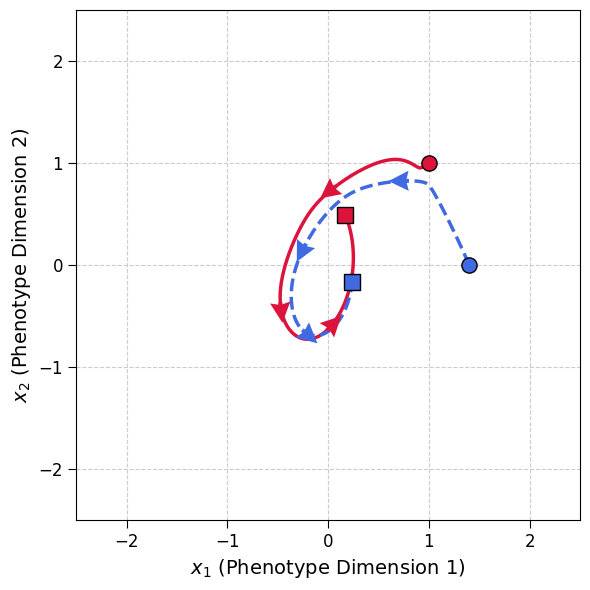

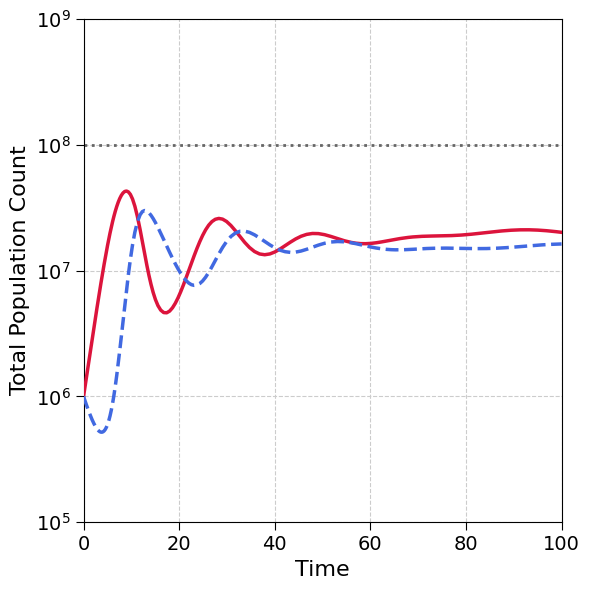

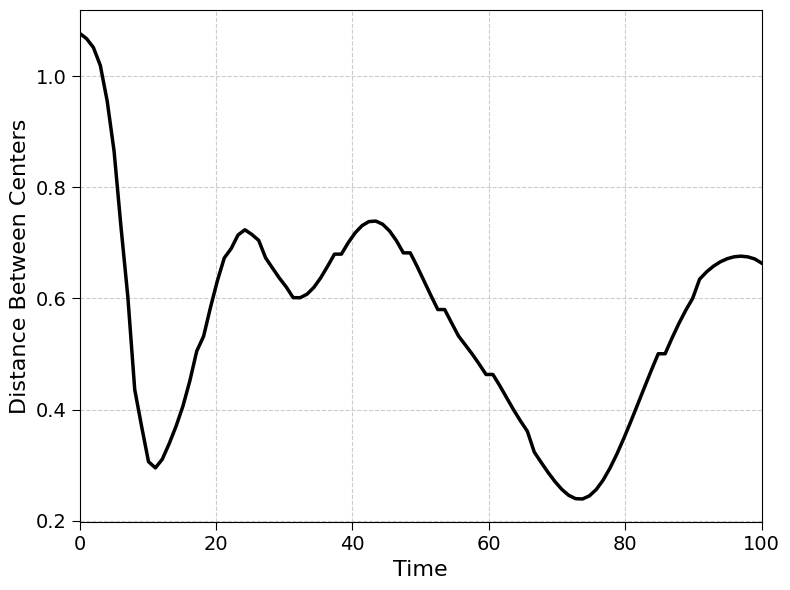

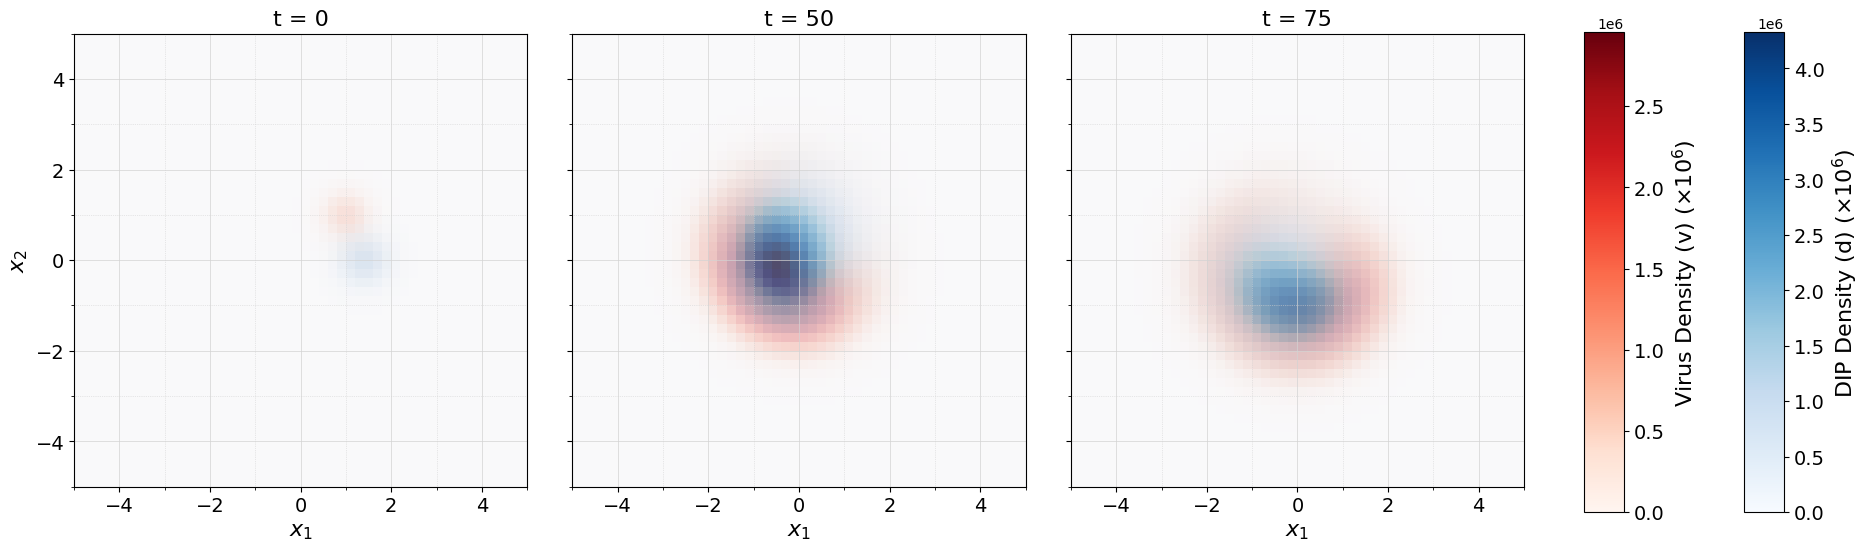

In [45]:
kernel_type = "power_law"
savedir = f'all_runs/kernels/{kernel_type}'
params = {
        "kernel_type": kernel_type,
        "kernel_params": kernels[kernel_type],
        "T": T_final,
        "nx": nx,
        "bord": bord,
        'mu': 1e-2
    }
results = sol_dip_virus_pde_fft(params)
plot_mean_phenotypes(results, mark_interval=25, base_fontsize=14,
                        save_path=f'{savedir}/S3a.svg', show_plot=True,
                        xlim = (-2.5, 2.5), ylim = (-2.5, 2.5),
                        arrow_length=0.2,             # NEW: Direct control of length in data units
                        arrow_width=0.03,              # NEW: Main control for thickness/bigness
                        arrow_head_width_ratio=5.0,    # NEW: Head width relative to shaft
                        arrow_head_length_ratio=5.0,
                        figsize=(6,6)) 
plot_total_populations(results, save_path=f'{savedir}/S3b.svg', figsize=(6,6), ylim=(1e5,1e9))
plot_euclidean_distance_over_time(results, (0, 100), 100, 
                                  save_path=f'{savedir}/S3c.svg', show_plot=True, figsize = (8,6))
plot_triple_heatmaps(results, nx, bord, (0, 50, 75),
                        figsize=(20, 8),
                        base_fontsize=16,
                        save_path=f'{savedir}/S3d.svg', 
                        show_plot=True)